In [1]:
# Feature Engineering for AML Detection Pipeline
# This notebook engineers features from the merged base sample dataset
# Input: data/processed/merged_base_sample.parquet
# Output: data/processed/merged_feature_engineered_sample.parquet

import pandas as pd
import numpy as np
import os
from pathlib import Path
import logging
import warnings

warnings.filterwarnings("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s | %(message)s')
logger = logging.getLogger(__name__)

# Visualization and ML imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

plt.style.use('seaborn-v0_8')

In [2]:
# Set project root and load merged base sample dataset
try:
    PROJECT_ROOT = Path.cwd()
    if not (PROJECT_ROOT / "data/processed/merged_base_sample.parquet").exists():
        PROJECT_ROOT = Path(r"C:\Users\Caxton Henry\.vscode\Anti-Money-Laundering-detection-and-Analysis-pipeline")
    os.chdir(PROJECT_ROOT)
except Exception as e:
    logger.error(f"Failed to set project root: {e}")
    PROJECT_ROOT = Path.cwd()

# Load the preprocessed merged base sample (no aggregates, clean labels)
logger.info(f"Loading merged base sample from {PROJECT_ROOT / 'data/processed/merged_base_sample.parquet'}")
merged = pd.read_parquet("data/processed/merged_base_sample.parquet")

logger.info(f"Loaded merged dataset shape: {merged.shape}")
logger.info(f"Columns: {merged.columns.tolist()}")
logger.info(f"Label distribution:\n{merged['Label'].value_counts()}")

2025-12-27 15:48:14,917 | INFO | Loading merged base sample from C:\Users\Caxton Henry\.vscode\Anti-Money-Laundering-detection-and-Analysis-pipeline\data\processed\merged_base_sample.parquet
2025-12-27 15:48:15,023 | INFO | Loaded merged dataset shape: (100000, 8)
2025-12-27 15:48:15,024 | INFO | Columns: ['AlertID', 'Timestamp', 'Entry', 'Type', 'Size', 'Date', 'Outcome', 'Label']
2025-12-27 15:48:15,035 | INFO | Label distribution:
Label
0    72400
1    27600
Name: count, dtype: int64


In [3]:
# Time-based Features
# Parse timestamp and extract temporal characteristics
logger.info("Engineering time-based features...")
merged['Timestamp'] = pd.to_datetime(merged['Timestamp'], errors='coerce')

merged['Hour'] = merged['Timestamp'].dt.hour
merged['Day'] = merged['Timestamp'].dt.day
merged['Month'] = merged['Timestamp'].dt.month
merged['Year'] = merged['Timestamp'].dt.year
merged['DayOfWeek'] = merged['Timestamp'].dt.dayofweek
merged['IsWeekend'] = (merged['DayOfWeek'] >= 5).astype(int)

logger.info(f"Time features created. Shape: {merged.shape}")

2025-12-27 15:48:23,148 | INFO | Engineering time-based features...
2025-12-27 15:48:23,233 | INFO | Time features created. Shape: (100000, 14)


In [4]:
# Velocity / Frequency Features
# These measure transaction activity patterns per alert
logger.info("Engineering velocity features...")

merged = merged.sort_values(['AlertID', 'Timestamp'])

# Transactions per hour per alert
merged['TxnPerHour'] = merged.groupby(['AlertID', 'Hour'])['Size'].transform('count')

# Transactions per day per alert
merged['TxnPerDay'] = merged.groupby(
    ['AlertID', merged['Timestamp'].dt.date]
)['Size'].transform('count')

# Time difference between consecutive transactions per alert (in seconds)
merged['TimeSinceLastTxn'] = merged.groupby('AlertID')['Timestamp'].diff().dt.total_seconds().fillna(0)

# Average time interval per alert
merged['AvgTxnInterval'] = merged.groupby('AlertID')['TimeSinceLastTxn'].transform('mean')

logger.info(f"Velocity features created. Shape: {merged.shape}")

2025-12-27 15:48:27,510 | INFO | Engineering velocity features...
2025-12-27 15:48:27,647 | INFO | Velocity features created. Shape: (100000, 18)


In [5]:
# Velocity Trend Features
# Capture changes and trends in transaction patterns
logger.info("Engineering trend features...")

merged['TxnPerHour_Diff'] = merged.groupby('AlertID')['TxnPerHour'].diff().fillna(0)
merged['TxnPerDay_Diff'] = merged.groupby('AlertID')['TxnPerDay'].diff().fillna(0)

# Rolling average of TxnPerHour (last 3 hours)
merged['RollingAvgTxnPerHour'] = merged.groupby('AlertID')['TxnPerHour'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)

logger.info(f"Trend features created. Shape: {merged.shape}")

2025-12-27 15:48:31,164 | INFO | Engineering trend features...
2025-12-27 15:48:31,230 | INFO | Trend features created. Shape: (100000, 21)


In [6]:
# Advanced Time-Based Features
# First/last transaction indicators and weekend patterns
logger.info("Engineering advanced time features...")

merged['IsFirstTxnOfDay'] = merged.groupby(['AlertID', 'Day'])['Timestamp'].transform(
    lambda x: x == x.min()
).astype(int)

merged['IsLastTxnOfDay'] = merged.groupby(['AlertID', 'Day'])['Timestamp'].transform(
    lambda x: x == x.max()
).astype(int)

# Fraction of weekend transactions per alert
merged['WeekendTxnRatio'] = merged.groupby('AlertID')['IsWeekend'].transform('mean')

# Burstiness: std / mean of transaction intervals per alert
merged['TxnBurstiness'] = merged.groupby('AlertID')['TimeSinceLastTxn'].transform(
    lambda x: x.std() / (x.mean() + 1e-6)
).fillna(0)

logger.info(f"Advanced time features created. Shape: {merged.shape}")

2025-12-27 15:48:47,101 | INFO | Engineering advanced time features...
2025-12-27 15:48:48,993 | INFO | Advanced time features created. Shape: (100000, 25)


In [7]:
# Transaction-Level Features
# Size-based derived features and categorical encoding
logger.info("Engineering transaction-level features...")

merged['AbsSize'] = merged['Size'].abs()
merged['LogSize'] = np.log1p(merged['AbsSize'])
merged['IsLargeTransaction'] = (merged['AbsSize'] > merged['AbsSize'].median()).astype(int)

# One-hot encode categorical columns
merged = pd.get_dummies(merged, columns=['Entry', 'Type'], drop_first=True)

logger.info(f"Transaction features and encoding complete. Shape: {merged.shape}")

2025-12-27 15:48:53,610 | INFO | Engineering transaction-level features...
2025-12-27 15:48:53,674 | INFO | Transaction features and encoding complete. Shape: (100000, 30)


In [8]:
# Rolling / Cumulative Transaction Features
# These are COMPUTED WITHIN EACH ALERT (train-time compatible)
# WARNING: These correlate with target if computed globally; must be recomputed per fold during ML
logger.info("Engineering rolling/cumulative features (will be recomputed per-fold during ML)...")

merged = merged.sort_values(['AlertID', 'Timestamp'])

# Rolling mean and std of last 3 transactions per alert
merged['RollingMean_3Txn'] = merged.groupby('AlertID')['AbsSize'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
merged['RollingStd_3Txn'] = merged.groupby('AlertID')['AbsSize'].transform(
    lambda x: x.rolling(3, min_periods=1).std().fillna(0)
)

# Cumulative sum and count of transactions per alert
merged['CumulativeTxnCount'] = merged.groupby('AlertID').cumcount() + 1
merged['CumulativeTxnSize'] = merged.groupby('AlertID')['AbsSize'].cumsum()

logger.info(f"Rolling/cumulative features created. Shape: {merged.shape}")

2025-12-27 15:48:59,008 | INFO | Engineering rolling/cumulative features (will be recomputed per-fold during ML)...
2025-12-27 15:48:59,156 | INFO | Rolling/cumulative features created. Shape: (100000, 34)


In [9]:
# Account-Level Features (if AccountID exists)
logger.info("Checking for account-level features...")
if 'AccountID' in merged.columns:
    logger.info("AccountID found, creating account-level features...")
    
    merged['AvgAccountTxn'] = merged.groupby('AccountID')['AbsSize'].transform('mean')
    merged['AccountTxnStd'] = merged.groupby('AccountID')['AbsSize'].transform('std').fillna(0)
    merged['MaxAccountTxn'] = merged.groupby('AccountID')['AbsSize'].transform('max')
    merged['CurrToMaxAccountTxn'] = merged['AbsSize'] / (merged['MaxAccountTxn'] + 1e-6)
    
    logger.info(f"Account-level features created. Shape: {merged.shape}")
else:
    logger.info("AccountID not found, skipping account-level features")

2025-12-27 15:49:07,924 | INFO | Checking for account-level features...
2025-12-27 15:49:07,927 | INFO | AccountID not found, skipping account-level features


In [10]:
# Account Behavioral Flags (if AccountID exists)
if 'AccountID' in merged.columns:
    logger.info("Creating account behavioral flags...")
    
    merged['AccountAlertCount'] = merged.groupby('AccountID')['AlertID'].transform('nunique')
    merged['AccountAvgTxnSize'] = merged.groupby('AccountID')['AbsSize'].transform('mean')
    merged['AccountMaxTxnSize'] = merged.groupby('AccountID')['AbsSize'].transform('max')
    merged['AccountStdTxnSize'] = merged.groupby('AccountID')['AbsSize'].transform('std').fillna(0)
    merged['CurrToAccountMaxTxn'] = merged['AbsSize'] / (merged['AccountMaxTxnSize'] + 1e-6)
    
    logger.info(f"Account behavioral flags created. Shape: {merged.shape}")
else:
    logger.info("AccountID not found, skipping account behavioral flags")

2025-12-27 15:49:12,719 | INFO | AccountID not found, skipping account behavioral flags


In [11]:
# Feature Interaction & Alert-Level Aggregation
logger.info("Creating feature interactions and aggregations...")

# Entry × Type interactions
merged['Entry_Type_Interaction'] = (
    merged.get('Entry_Debit', 0) * merged.get('Type_Wire', 0)
)

# Alert-level statistical aggregations
agg_features = merged.groupby('AlertID').agg({
    'AbsSize': ['mean', 'max', 'min', 'std'],
    'IsLargeTransaction': 'sum',
}).fillna(0)

agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns]
merged = merged.merge(agg_features, on='AlertID', how='left')

logger.info(f"Feature engineering complete. Dataset shape: {merged.shape}")
logger.info(f"Total columns: {merged.shape[1]}")
logger.info(f"Sample columns: {merged.columns.tolist()[:20]}")

2025-12-27 15:49:18,040 | INFO | Creating feature interactions and aggregations...
2025-12-27 15:49:18,098 | INFO | Feature engineering complete. Dataset shape: (100000, 40)
2025-12-27 15:49:18,100 | INFO | Total columns: 40
2025-12-27 15:49:18,102 | INFO | Sample columns: ['AlertID', 'Timestamp', 'Size', 'Date', 'Outcome', 'Label', 'Hour', 'Day', 'Month', 'Year', 'DayOfWeek', 'IsWeekend', 'TxnPerHour', 'TxnPerDay', 'TimeSinceLastTxn', 'AvgTxnInterval', 'TxnPerHour_Diff', 'TxnPerDay_Diff', 'RollingAvgTxnPerHour', 'IsFirstTxnOfDay']


In [12]:
# Enhanced Alert-Level Aggregation Features
# Statistical summaries per alert
logger.info("Creating enhanced alert-level aggregations...")

agg = merged.groupby("AlertID").agg(
    AbsSize_mean=("AbsSize", "mean"),
    AbsSize_median=("AbsSize", "median"),
    AbsSize_std=("AbsSize", "std"),
    AbsSize_min=("AbsSize", "min"),
    AbsSize_max=("AbsSize", "max"),
    AbsSize_range=("AbsSize", lambda x: x.max() - x.min()),
    AbsSize_skew=("AbsSize", "skew"),
    
    LogSize_mean=("LogSize", "mean"),
    LogSize_std=("LogSize", "std"),

    TotalTxnCount=("Size", "count"),
    LargeTxnCount=("IsLargeTransaction", "sum"),
    
    # Ratio features
    LargeTxnRatio=("IsLargeTransaction", lambda x: x.sum() / len(x) if len(x) > 0 else 0),

    # Time-based burstiness
    Hour_std=("Hour", "std"),
    DayOfWeek_std=("DayOfWeek", "std"),
).fillna(0)

# Merge back into main DataFrame
merged = merged.merge(agg, on="AlertID", how="left")

logger.info(f"Enhanced aggregation features added. Shape: {merged.shape}")

2025-12-27 15:49:22,983 | INFO | Creating enhanced alert-level aggregations...
2025-12-27 15:49:23,087 | INFO | Enhanced aggregation features added. Shape: (100000, 54)


In [13]:
# Derived Ratios & Alert-Specific Aggregation Features
logger.info("Creating derived ratio features...")

merged['MaxToMedianTxnRatio'] = merged.groupby('AlertID')['AbsSize'].transform('max') / (
    merged.groupby('AlertID')['AbsSize'].transform('median') + 1e-6
)

# Fraction of transactions above 5,000 USD per alert
merged['HighTxnRatio'] = merged.groupby('AlertID')['AbsSize'].transform(
    lambda x: (x > 5000).sum() / len(x) if len(x) > 0 else 0
)

# Cash to Wire transaction ratio per alert (if one-hot encoded columns exist)
if 'Type_Cash' in merged.columns and 'Type_Wire' in merged.columns:
    merged['CashToWireRatio'] = merged.groupby('AlertID')['Type_Cash'].transform('sum') / (
        merged.groupby('AlertID')['Type_Wire'].transform('sum') + 1e-6
    )

logger.info(f"Ratio features created. Shape: {merged.shape}")

2025-12-27 15:49:29,093 | INFO | Creating derived ratio features...
2025-12-27 15:49:29,135 | INFO | Ratio features created. Shape: (100000, 57)


In [14]:
# Typology & Domain-Specific Flags (AML-Specific Behavioral Indicators)
logger.info("Creating AML-specific typology flags...")

# Round-number transactions (potential structuring)
merged['IsRoundAmount'] = (merged['AbsSize'] % 100 == 0).astype(int)

# Threshold-proximity transactions (just below $10k reporting threshold)
threshold = 10000
merged['JustBelowThreshold'] = (
    (merged['AbsSize'] >= (threshold * 0.9)) & (merged['AbsSize'] < threshold)
).astype(int)

# Credit vs. Debit ratio per alert
if 'Entry_Debit' in merged.columns and 'Entry_Credit' in merged.columns:
    merged['Alert_CreditRatio'] = merged.groupby('AlertID')['Entry_Credit'].transform('sum') / (
        merged.groupby('AlertID')['Entry_Credit'].transform('sum') +
        merged.groupby('AlertID')['Entry_Debit'].transform('sum') + 1e-6
    )
else:
    merged['Alert_CreditRatio'] = 0

# Wire transfer / cash indicators (if one-hot encoded columns exist)
for col in ['Type_Wire', 'Type_Cash']:
    if col in merged.columns:
        merged[f'Alert_{col}_Count'] = merged.groupby('AlertID')[col].transform('sum')

# Alert concentration of large transactions
merged['Alert_LargeTxnRatio'] = merged.groupby('AlertID')['IsLargeTransaction'].transform(
    lambda x: x.sum() / len(x) if len(x) > 0 else 0
)

# Fill NaNs and infinities
merged = merged.fillna(0)
merged = merged.replace([np.inf, -np.inf], 0)

logger.info(f"Typology flags created. Shape: {merged.shape}")

2025-12-27 15:49:33,135 | INFO | Creating AML-specific typology flags...
2025-12-27 15:49:33,320 | INFO | Typology flags created. Shape: (100000, 63)


In [15]:
# Final Feature Selection & ML Preparation
logger.info("Preparing features for ML...")

# Define target column
target_col = 'Label'

# Drop identifiers / columns not needed for ML
drop_cols = ['AlertID', 'Timestamp', 'Date', 'Outcome', target_col]
merged_ml = merged.drop(columns=[col for col in drop_cols if col in merged.columns], errors='ignore')

# Select numeric features only (for most ML models)
X = merged_ml.select_dtypes(include=['number'])
y = merged[target_col]

logger.info(f"Features selected for ML: {X.shape[1]} columns")
logger.info(f"Target shape: {y.shape}")
logger.info(f"Class distribution:\n{y.value_counts()}")
logger.info(f"Sample feature names: {X.columns.tolist()[:15]}")

2025-12-27 15:49:38,635 | INFO | Preparing features for ML...
2025-12-27 15:49:38,664 | INFO | Features selected for ML: 53 columns
2025-12-27 15:49:38,664 | INFO | Target shape: (100000,)
2025-12-27 15:49:38,670 | INFO | Class distribution:
Label
0    72400
1    27600
Name: count, dtype: int64
2025-12-27 15:49:38,671 | INFO | Sample feature names: ['Size', 'Hour', 'Day', 'Month', 'Year', 'DayOfWeek', 'IsWeekend', 'TxnPerHour', 'TxnPerDay', 'TimeSinceLastTxn', 'AvgTxnInterval', 'TxnPerHour_Diff', 'TxnPerDay_Diff', 'RollingAvgTxnPerHour', 'IsFirstTxnOfDay']


In [16]:
# Final Export: Feature-Engineered Sample Dataset
logger.info("Exporting feature-engineered sample dataset...")

# Create directory if it doesn't exist
export_dir = "data/processed"
os.makedirs(export_dir, exist_ok=True)

# Select numeric features + target
feature_cols = merged.select_dtypes(include=['number']).columns.tolist()

# Keep target and all numeric features (no filtering - let downstream notebooks decide)
if 'Label' not in feature_cols and 'Label' in merged.columns:
    feature_cols.append('Label')

export_df = merged[feature_cols]

# Export feature-engineered sample
export_path = os.path.join(export_dir, "merged_feature_engineered_sample.parquet")
export_df.to_parquet(export_path, index=False)

logger.info(f"✓ Feature-engineered dataset exported: {export_path}")
logger.info(f"  Shape: {export_df.shape}")
logger.info(f"  Columns: {export_df.shape[1]}")
logger.info(f"  Sample features: {export_df.columns.tolist()[:15]}")

2025-12-27 15:49:45,032 | INFO | Exporting feature-engineered sample dataset...
2025-12-27 15:49:45,244 | INFO | ✓ Feature-engineered dataset exported: data/processed\merged_feature_engineered_sample.parquet
2025-12-27 15:49:45,246 | INFO |   Shape: (100000, 55)
2025-12-27 15:49:45,247 | INFO |   Columns: 55
2025-12-27 15:49:45,248 | INFO |   Sample features: ['AlertID', 'Size', 'Label', 'Hour', 'Day', 'Month', 'Year', 'DayOfWeek', 'IsWeekend', 'TxnPerHour', 'TxnPerDay', 'TimeSinceLastTxn', 'AvgTxnInterval', 'TxnPerHour_Diff', 'TxnPerDay_Diff']


2025-12-27 15:49:48,940 | INFO | Performing correlation analysis...
2025-12-27 15:49:49,780 | INFO | Highly correlated features (|corr| > 0.85): 17
2025-12-27 15:49:49,780 | INFO |   Examples: ['TxnPerDay', 'RollingAvgTxnPerHour', 'LogSize', 'CumulativeTxnSize', 'AbsSize_std_x', 'AbsSize_mean_y', 'AbsSize_median', 'AbsSize_std_y', 'AbsSize_min_y', 'AbsSize_max_y']


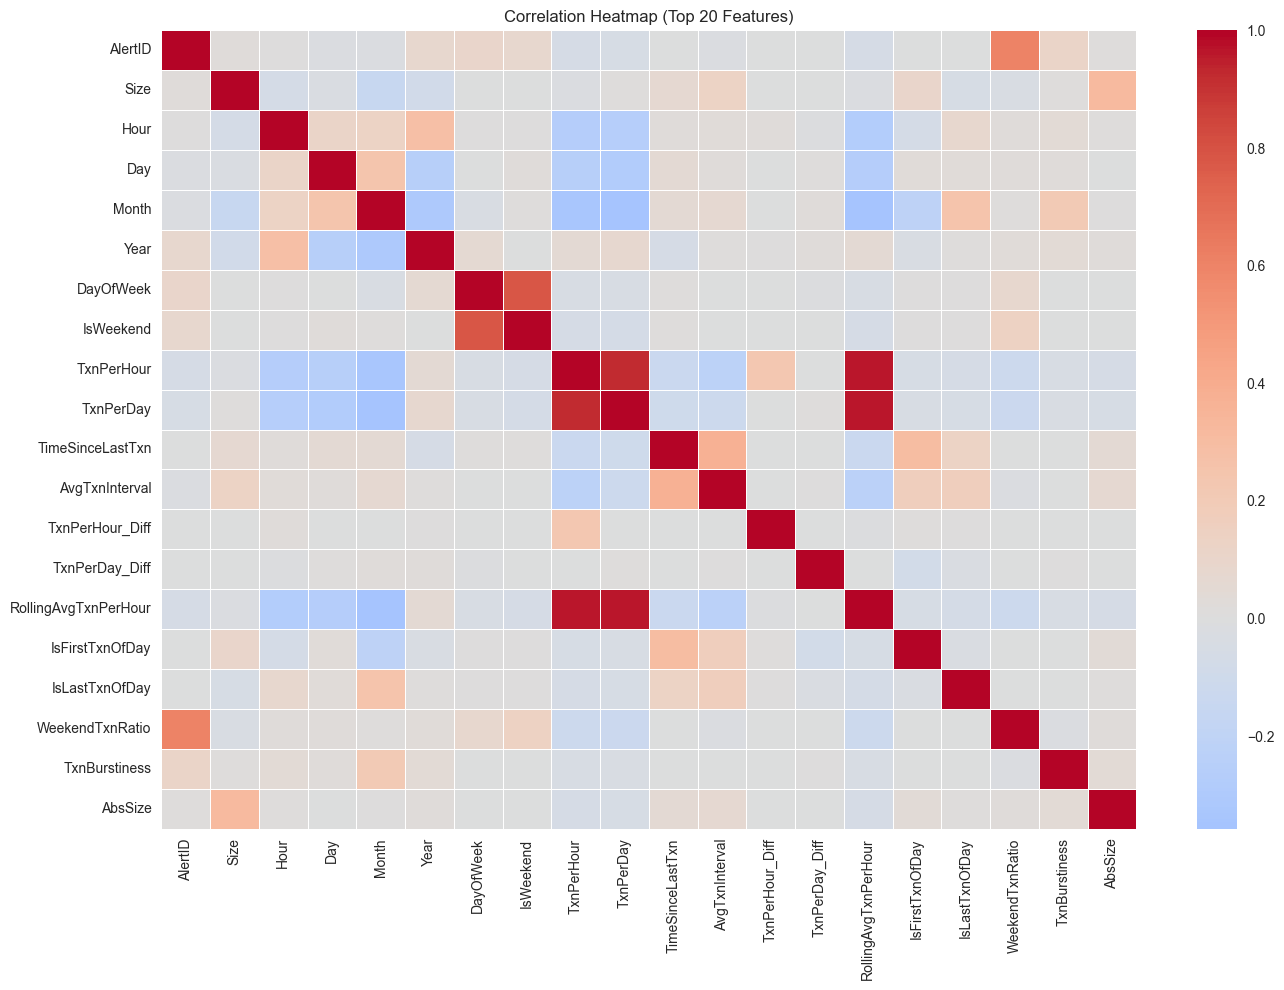

2025-12-27 15:49:50,526 | INFO | Correlation analysis complete. Dataset ready for modeling.


In [17]:
# Correlation Analysis & Feature Exploration
logger.info("Performing correlation analysis...")

# Select numeric features only
numeric_features = merged.select_dtypes(include=['number']).drop(columns=['Label'], errors='ignore')

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Identify highly correlated features (threshold > 0.85)
threshold = 0.85
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column].abs() > threshold)]

logger.info(f"Highly correlated features (|corr| > {threshold}): {len(high_corr_features)}")
if high_corr_features:
    logger.info(f"  Examples: {high_corr_features[:10]}")

# Plot heatmap of top correlated features (sample to avoid overcrowding)
if len(numeric_features.columns) > 30:
    top_cols = numeric_features.corr()['Label'].abs().nlargest(20).index.tolist() if 'Label' in numeric_features.columns else numeric_features.columns[:20]
else:
    top_cols = numeric_features.columns

if len(top_cols) > 1:
    plt.figure(figsize=(14, 10))
    sns.heatmap(numeric_features[top_cols].corr(), cmap='coolwarm', center=0, linewidths=0.5, annot=False)
    plt.title(f"Correlation Heatmap (Top {len(top_cols)} Features)")
    plt.tight_layout()
    plt.show()

logger.info(f"Correlation analysis complete. Dataset ready for modeling.")